In [ ]:
# CUDNN 12.6 검색
# https://developer.nvidia.com/rdp/cudnn-archive

# 배치 정규화와 드롭아웃 비교 (PyTorch 2.8 버전)
# 0) 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
import torchvision.transforms as transforms

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device} / PyTorch version: {torch.__version__}")

using device: cuda / PyTorch version: 2.2.2


In [2]:
# 1) 데이터 불러오기 및 텐서로 변경
def load_fashion_mnist(val_split=0.2, batch_size=32):
    train_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,)),
        ]
    )

    test_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.2860,), (0.3530,))]
    )

    full_trainset = torchvision.datasets.FashionMNIST(
        root="./data", train=True, download=True, transform=train_transform
    )

    testset = torchvision.datasets.FashionMNIST(
        root="./data", train=False, download=True, transform=test_transform
    )

    train_size = int((1 - val_split) * len(full_trainset))
    val_size = len(full_trainset) - train_size
    trainset, valset = random_split(full_trainset, [train_size, val_size])

    valset.dataset = torchvision.datasets.FashionMNIST(
        root="./data", train=True, download=False, transform=test_transform
    )

    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=0)

    test_loader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=0
    )

    return train_loader, val_loader, test_loader, len(full_trainset.classes)


def visualize_samples(data_loader, num_samples=8):
    images, labels = next(iter(data_loader))

    class_names = [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(num_samples):
        row, col = i // 4, i % 4
        axes[row, col].imshow(images[i].squeeze(), cmap="gray")
        axes[row, col].set_title(f"{class_names[labels[i]]}")
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

BATCH_SIZE = 512
VAL_SPLIT = 0.1
train_loader, val_loader, test_loader, num_classes = load_fashion_mnist(batch_size=BATCH_SIZE, val_split=VAL_SPLIT)

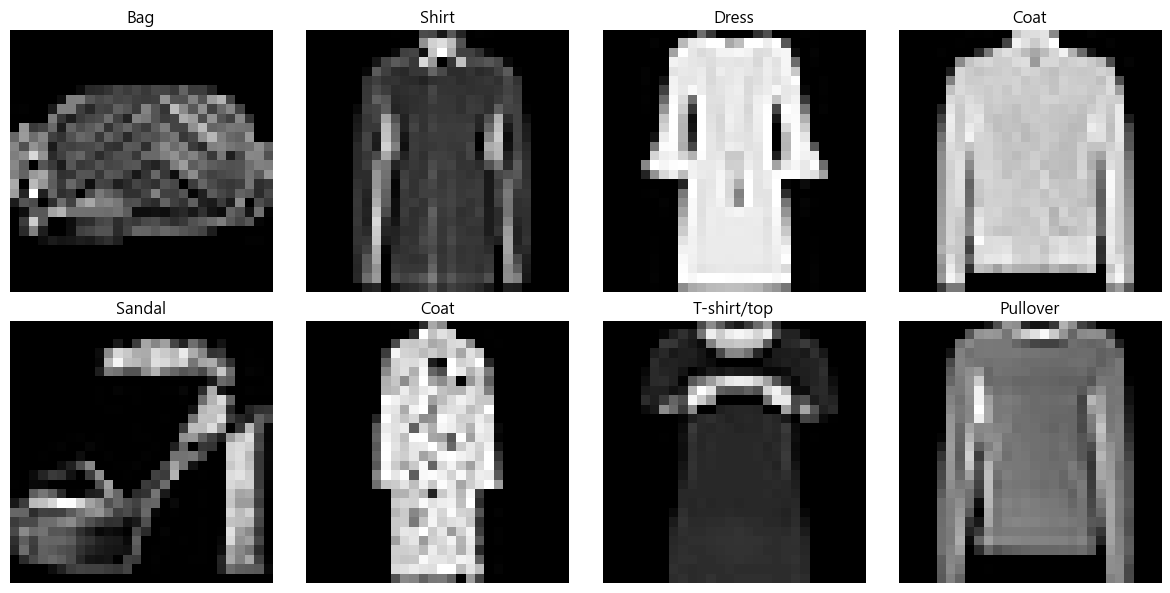

In [3]:
visualize_samples(train_loader)

In [8]:
# 2) 모델 정의

class BaselineNet(nn.Module):
    def __init__(
        self,
        input_size=784,
        hidden_sizes=[512, 256, 128],
        num_classes=10,
        dropout_rate=0.0,
    ):
        super().__init__()

        layers = []
        prev_size = input_size

        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, num_classes))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.classifier(x)


# 2) 모델 정의2
class BatchNormNet(nn.Module):
    def __init__(
        self,
        input_size=784,
        hidden_sizes=[512, 256, 128],
        num_classes=10,
        dropout_rate=0.0,
    ):
        super().__init__()

        layers = []
        prev_size = input_size

        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, num_classes))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# 모델들 초기화 및 학습
models_config = {
    "Normal": BaselineNet(num_classes=num_classes),
    "BatchNormal": BatchNormNet(num_classes=num_classes),
    "Normal(Dropout)": BaselineNet(num_classes=num_classes, dropout_rate=0.2),
    "BatchNormal(Dropout)": BatchNormNet(num_classes=num_classes, dropout_rate=0.2),
}

In [9]:
# 3) 모델 학습 함수들
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs.data, 1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()
    return 100 * correct / total


def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total_batches = len(train_loader)

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        batch_acc = calculate_accuracy(output, target)
        running_acc += batch_acc

        if batch_idx % 100 == 0:
            avg_loss = running_loss / (batch_idx + 1)
            avg_acc = running_acc / (batch_idx + 1)
            print(
                f"batch [{batch_idx}/{len(train_loader)}] - "
                f"loss: {avg_loss:.4f}, "
                f"acc: {avg_acc:.4f}%"
            )

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)

    return epoch_loss, epoch_acc


def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            running_acc += calculate_accuracy(output, target)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_acc / len(val_loader)

    return epoch_loss, epoch_acc


def train_model(
    model, train_loader, val_loader, device, epochs=20, learning_rate=0.001
):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print("train start...")

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")

        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, device
        )

        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)

    return {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
    }


trained_models = {}
for name, model in models_config.items():
    print(f"{name} 모델 학습 중...")
    print(f"{'-'*70}")
    result = train_model(model, train_loader, val_loader, device, epochs=5)
    trained_models[name] = result


Normal 모델 학습 중...
----------------------------------------------------------------------
train start...

Epoch [1/5]
batch [0/106] - loss: 2.3083, acc: 7.8125%
batch [100/106] - loss: 0.6342, acc: 77.7769%
  Train Loss: 0.6232, Train Acc: 78.15%
  Val Loss: 0.4271, Val Acc: 85.26%
  Learning Rate: 0.000905
------------------------------------------------------------

Epoch [2/5]
batch [0/106] - loss: 0.4342, acc: 84.3750%
batch [100/106] - loss: 0.3867, acc: 85.9452%
  Train Loss: 0.3860, Train Acc: 85.94%
  Val Loss: 0.3620, Val Acc: 87.03%
  Learning Rate: 0.000655
------------------------------------------------------------

Epoch [3/5]
batch [0/106] - loss: 0.3799, acc: 86.1328%
batch [100/106] - loss: 0.3283, acc: 88.0879%
  Train Loss: 0.3291, Train Acc: 88.06%
  Val Loss: 0.3368, Val Acc: 87.49%
  Learning Rate: 0.000346
------------------------------------------------------------

Epoch [4/5]
batch [0/106] - loss: 0.3173, acc: 87.8906%
batch [100/106] - loss: 0.2984, acc: 88.97

In [ ]:
# 4) 모델 평가

def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    true_labels = []

    criterion = nn.CrossEntropyLoss()

    total_batches = len(test_loader)

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            predictions.extend(pred.cpu().numpy().flatten())
            true_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    return {
        "test_loss": test_loss,
        "accuracy": accuracy,
        "predictions": predictions,
        "true_labels": true_labels,
    }

results = {}

for name, trained_model in trained_models.items():
    print(f"\n{name} model evaluation")
    result = evaluate_model(trained_model["model"], test_loader, device)
    results[name] = result
    print(
        f"{name}: test accuracy = {result['accuracy']:.2f}%, test loss = {result['test_loss']:.4f}"
    )